In [1]:
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scienceplots
from matplotlib import tri
from matplotlib.colors import TwoSlopeNorm
from qutip import (
    average_gate_fidelity,
    destroy,
    process_fidelity,
    propagator,
    qeye,
    spost,
    spre,
    tensor,
)
from qutip_qip.operations import ISWAP, SQRTISWAP
from tqdm.notebook import tqdm

In [2]:
# Parameters for the simulation
target_fidelity = 0.99  # Target fidelity (e.g., 99%)
N = 32  # Number of data points for fidelity plots
g3 = 60e6  # Coupling strength g3 = 60 MHz
n_s_list = np.linspace(2, 5, N)  # Pump photon number values
delta_list = 1e6 * np.linspace(50, 250, N)  # Detuning values in Hz

# iSWAP and sqrt(iSWAP combinations)
iswap_choices = [True]  # , False]  # True for iSWAP, False for sqrt(iSWAP)
lambdaqs = [0.08, 0.1]  # Different lambda values
T1_values = [80e-6, 160e-6]  # T1 values in seconds

num_qubits = 4
q1, q2, q3, q4 = [
    tensor(*[destroy(2) if i == j else qeye(2) for i in range(num_qubits)])
    for j in range(num_qubits)
]

In [3]:
def build_propagator(T1, delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2):
    """Builds and returns the propagator for the system with the given parameters.

    --------
    U_diss : Qobj
        The unitary propagator including dissipation (if specified).
    t_f : float
        The duration of the gate based on the effective coupling.
    """
    # Calculate effective coupling and gate duration t_f
    eta = np.sqrt(n_s)
    g_eff = 6 * g3 * (lambdaq**2) * eta
    t_f = full_pulse / g_eff  # Duration of the gate based on effective coupling

    # Define the target and spectator interactions
    target_interaction = q1.dag() * q2 + q1 * q2.dag()
    spectator_interaction = q3.dag() * q4 + q3 * q4.dag()

    # Dissipation (amplitude damping) setup
    _gamma = 1 / T1
    c_ops = [
        np.sqrt(_gamma) * q1,
        np.sqrt(_gamma) * q2,
        np.sqrt(_gamma) * q3,
        np.sqrt(_gamma) * q4,
    ]

    # Build the total Hamiltonian as a list of time-dependent components
    # H = [[target_interaction, H1_coeff], [spectator_interaction, H2_coeff]]
    H_int = (
        -g_eff * target_interaction
        + -g_eff * (1 / np.log(2)) * (2 / delta) * spectator_interaction / t_f
    )

    # U_spec = (-1j * H_int).expm()

    # Use QuTiP's propagator function to calculate the time evolution
    U_diss = propagator(H_int, t_f, c_ops)

    return U_diss, t_f

In [4]:
# Data collection code with build_propagator()
# Data structure to hold all the results
data_store = []

# Step 1: Collect Data
for iswap_choice in iswap_choices:
    for lambdaq in lambdaqs:
        for T1 in T1_values:
            # Choose between iSWAP and sqrt(iSWAP)
            full_pulse = np.pi / 2 if iswap_choice else np.pi / 4
            intended_gate = (
                ISWAP([0, 1]).get_compact_qobj()
                if iswap_choice
                else SQRTISWAP([0, 1]).get_compact_qobj()
            )
            gate_type = "iSWAP" if iswap_choice else r"$\sqrt{iSWAP}$"

            # Fidelity and gate duration data storage
            fidelity_list = []
            n_s_points = []
            delta_points = []
            gate_durations = []

            # Fidelity calculation loop
            for delta in tqdm(
                delta_list,
                desc=f"Processing {gate_type}, lambda={lambdaq}, T1={T1*1e6} µs",
            ):
                for n_s in n_s_list:

                    # Call build_propagator to get the propagator for the system
                    U_diss, t_f = build_propagator(
                        T1,
                        delta,
                        lambdaq=lambdaq,
                        g3=g3,
                        n_s=n_s,
                        full_pulse=full_pulse,
                    )

                    # Fidelity calculation with target gate
                    target_iswap = tensor(intended_gate, qeye([2, 2]))
                    fidelity = 1 - (average_gate_fidelity(U_diss, target_iswap))

                    # Store data in lists
                    fidelity_list.append(fidelity)
                    n_s_points.append(n_s)
                    delta_points.append(
                        delta / 1e6
                    )  # Convert delta to MHz for plotting
                    gate_durations.append(
                        t_f * 1e9
                    )  # Store gate duration in nanoseconds

            # Store all data in a dictionary
            data_store.append(
                {
                    "gate_type": gate_type,
                    "lambdaq": lambdaq,
                    "T1": T1,
                    "fidelity_list": np.array(fidelity_list),
                    "n_s_points": np.array(n_s_points),
                    "delta_points": np.array(delta_points),
                    "gate_durations": np.array(gate_durations),
                }
            )

Processing iSWAP, lambda=0.08, T1=80.0 µs:   0%|          | 0/32 [00:00<?, ?it/s]

/home/evm9/corral_crowding/.venv/lib/python3.12/site-packages/qutip/solver/integrator/scipy_integrator.py:80: SparseEfficiencyWarning: Constructing a DIA matrix with 256 diagonals is inefficient
  state0 = _data.column_stack(state0)


Processing iSWAP, lambda=0.08, T1=160.0 µs:   0%|          | 0/32 [00:00<?, ?it/s]

Processing iSWAP, lambda=0.1, T1=80.0 µs:   0%|          | 0/32 [00:00<?, ?it/s]

Processing iSWAP, lambda=0.1, T1=160.0 µs:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: ../../img/qubit_spectator_boundaries/iSWAP_lambda_008_T1_80_us.pdf


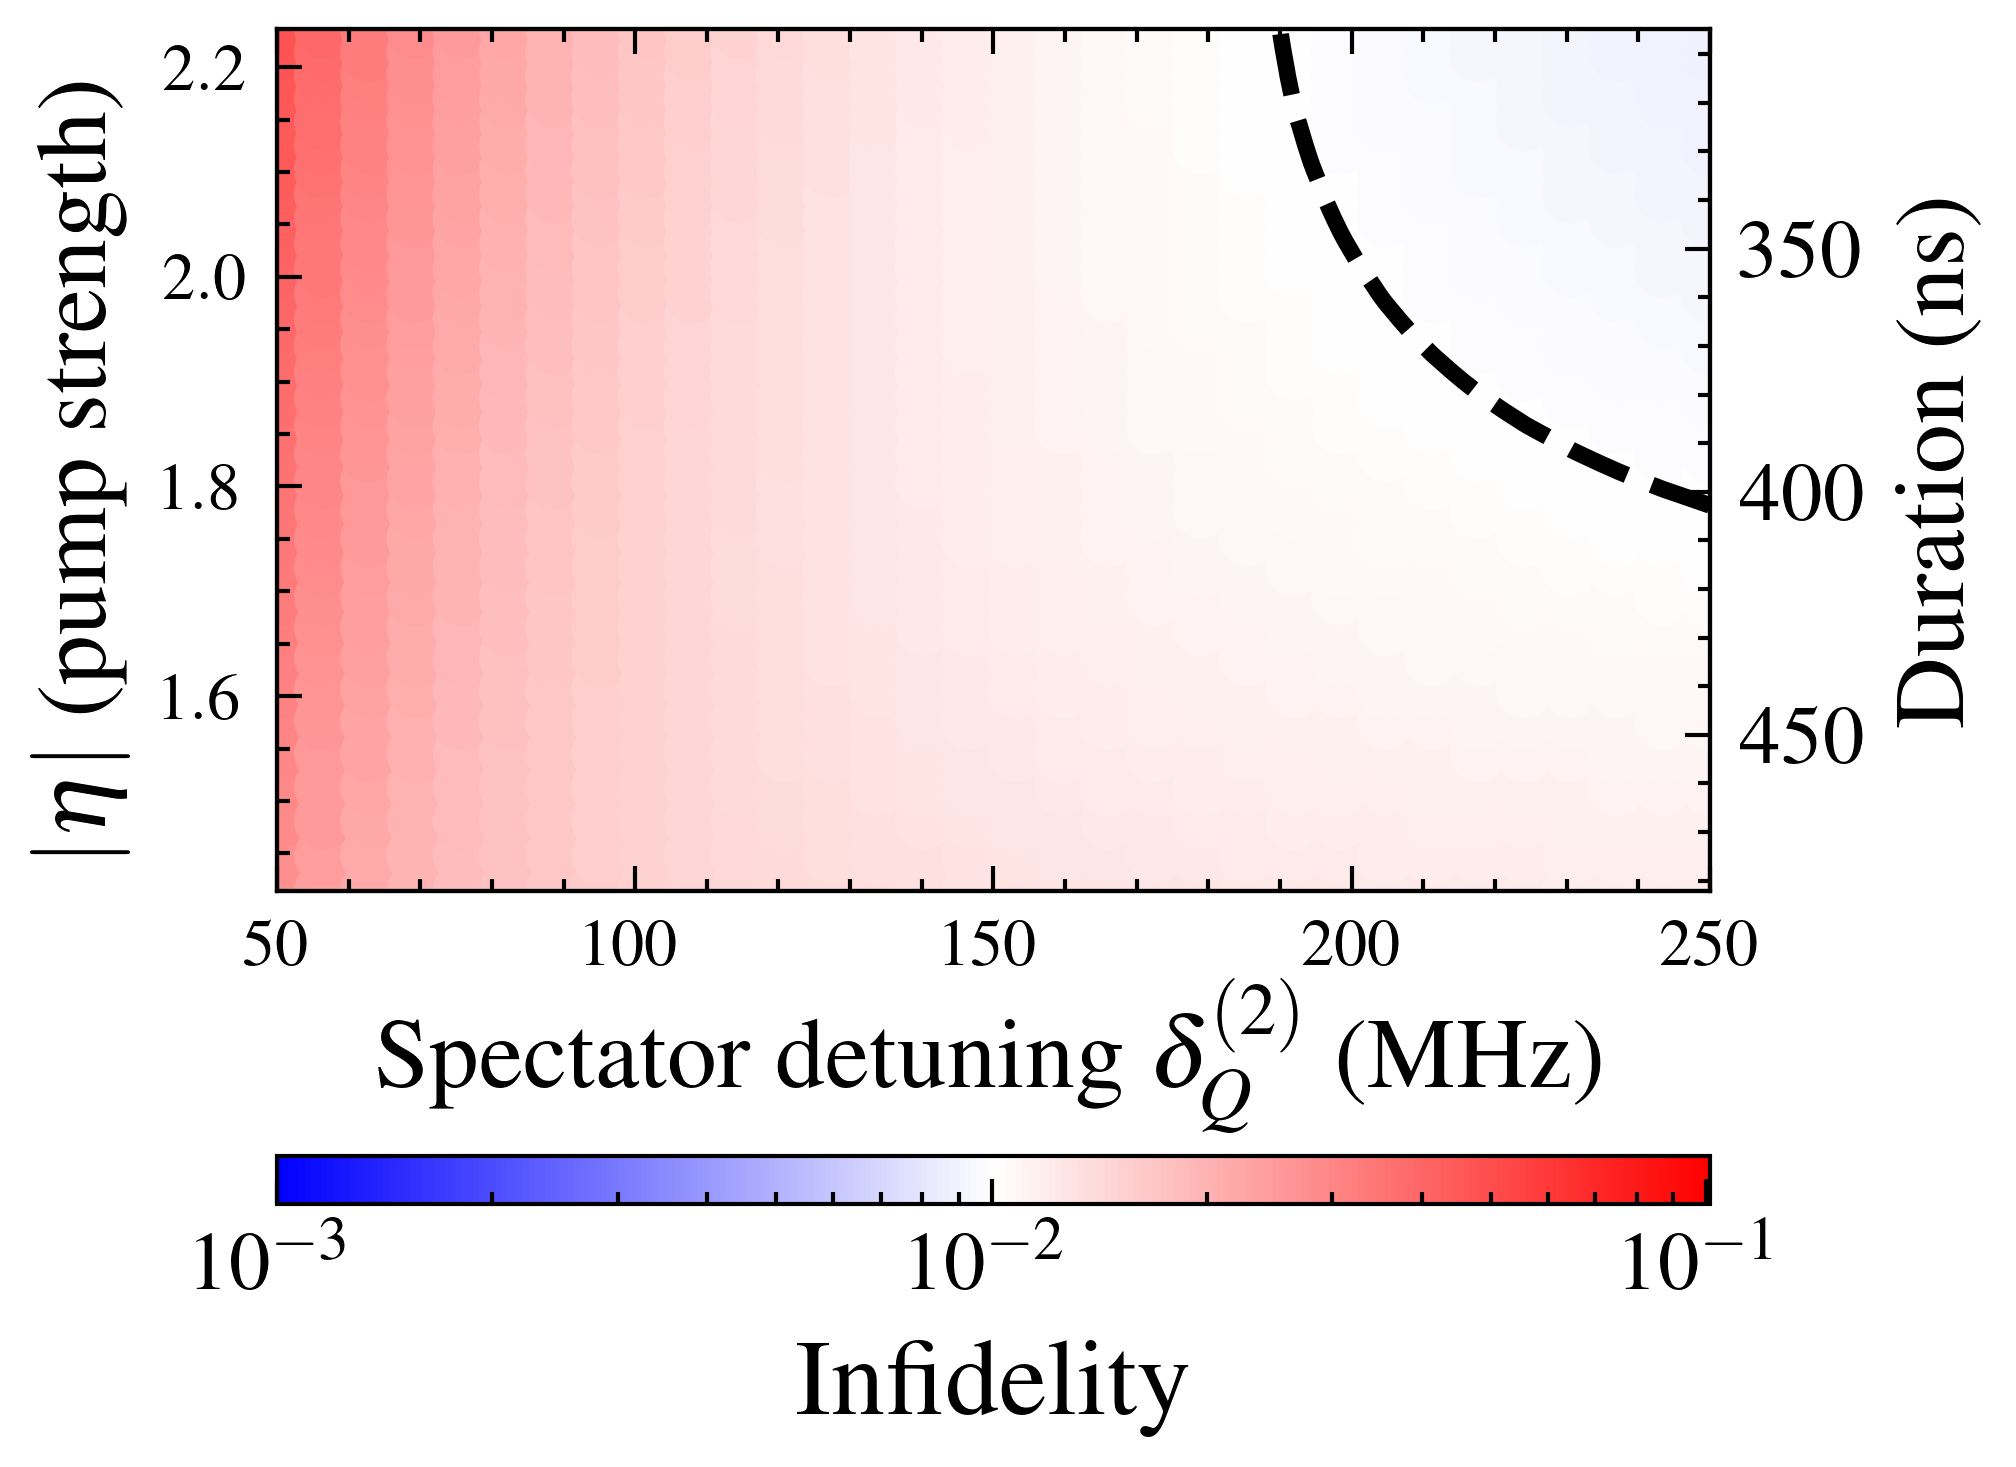

Saved: ../../img/qubit_spectator_boundaries/iSWAP_lambda_008_T1_160_us.pdf


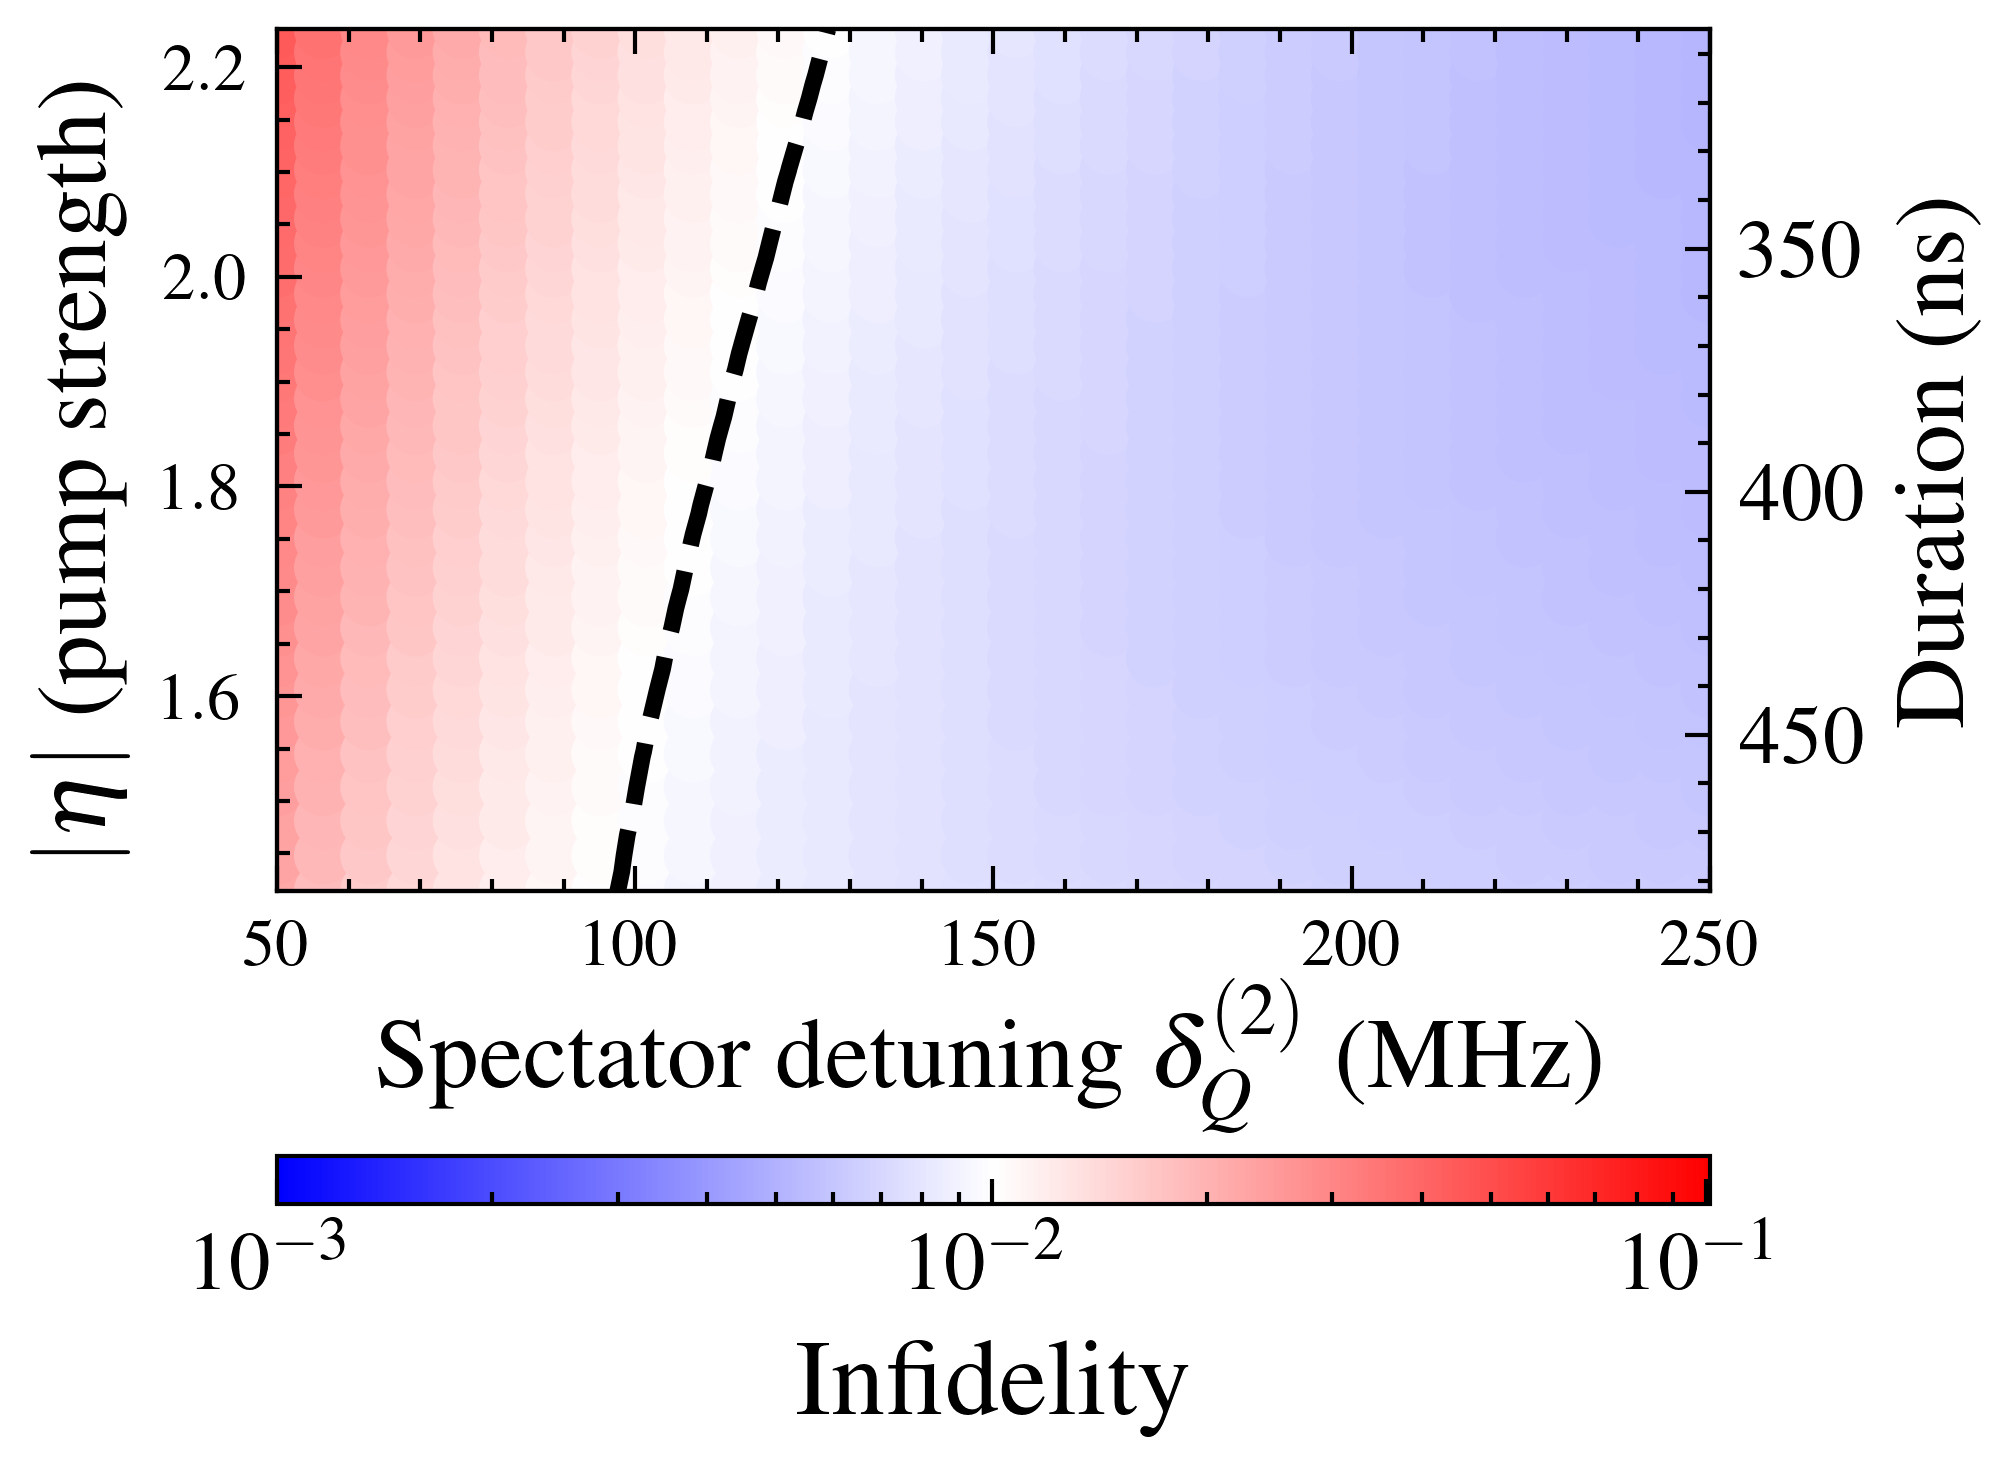

Saved: ../../img/qubit_spectator_boundaries/iSWAP_lambda_01_T1_80_us.pdf


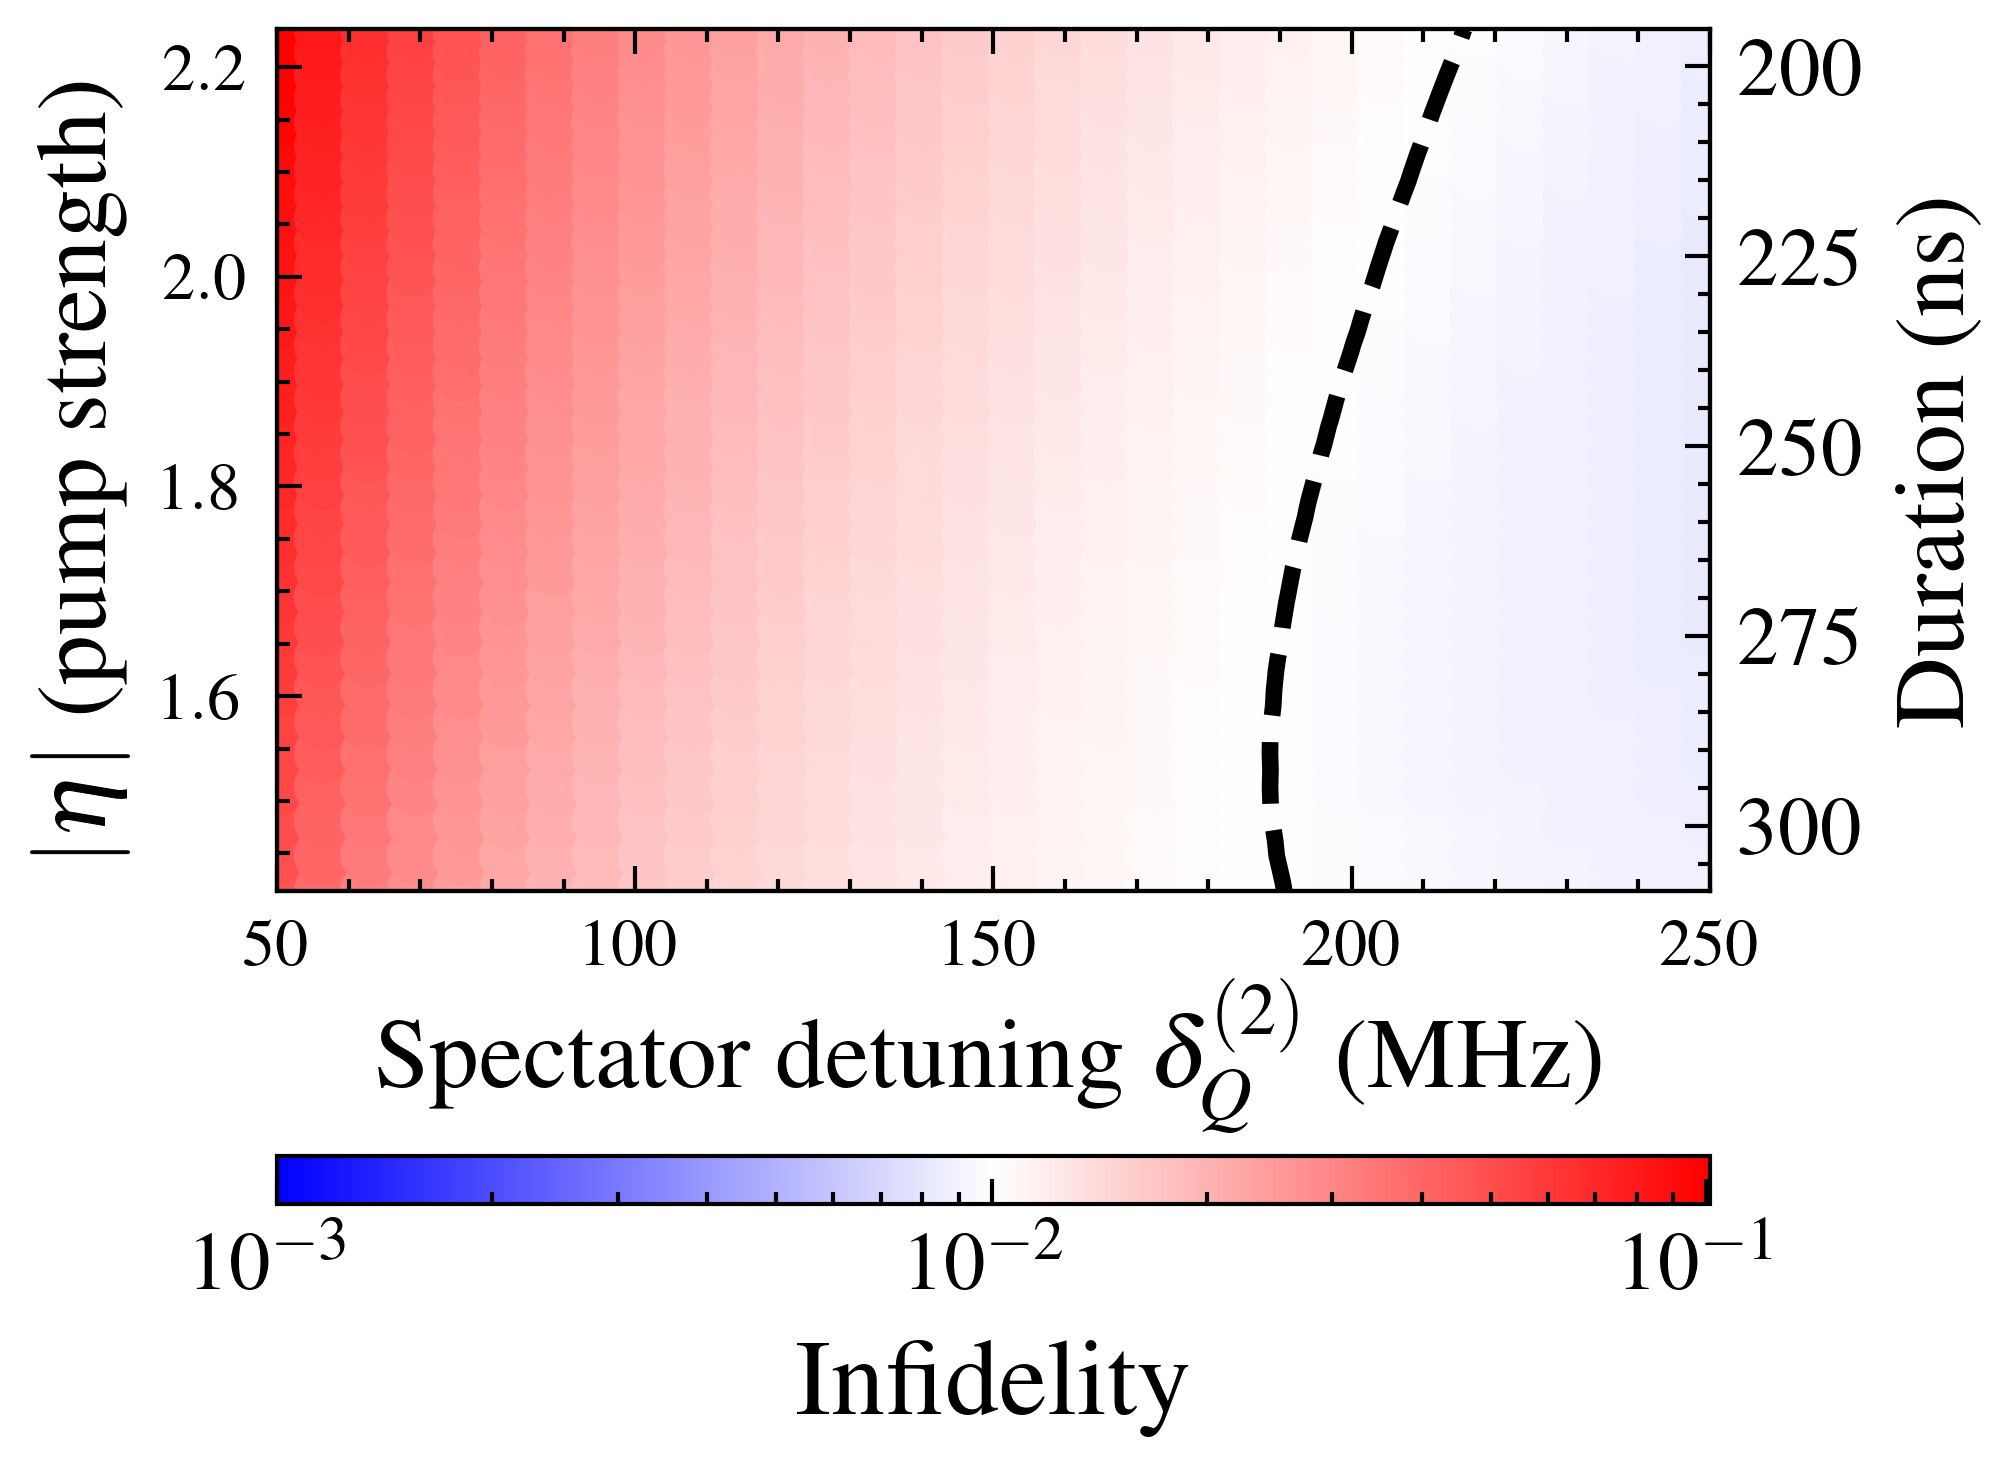

Saved: ../../img/qubit_spectator_boundaries/iSWAP_lambda_01_T1_160_us.pdf


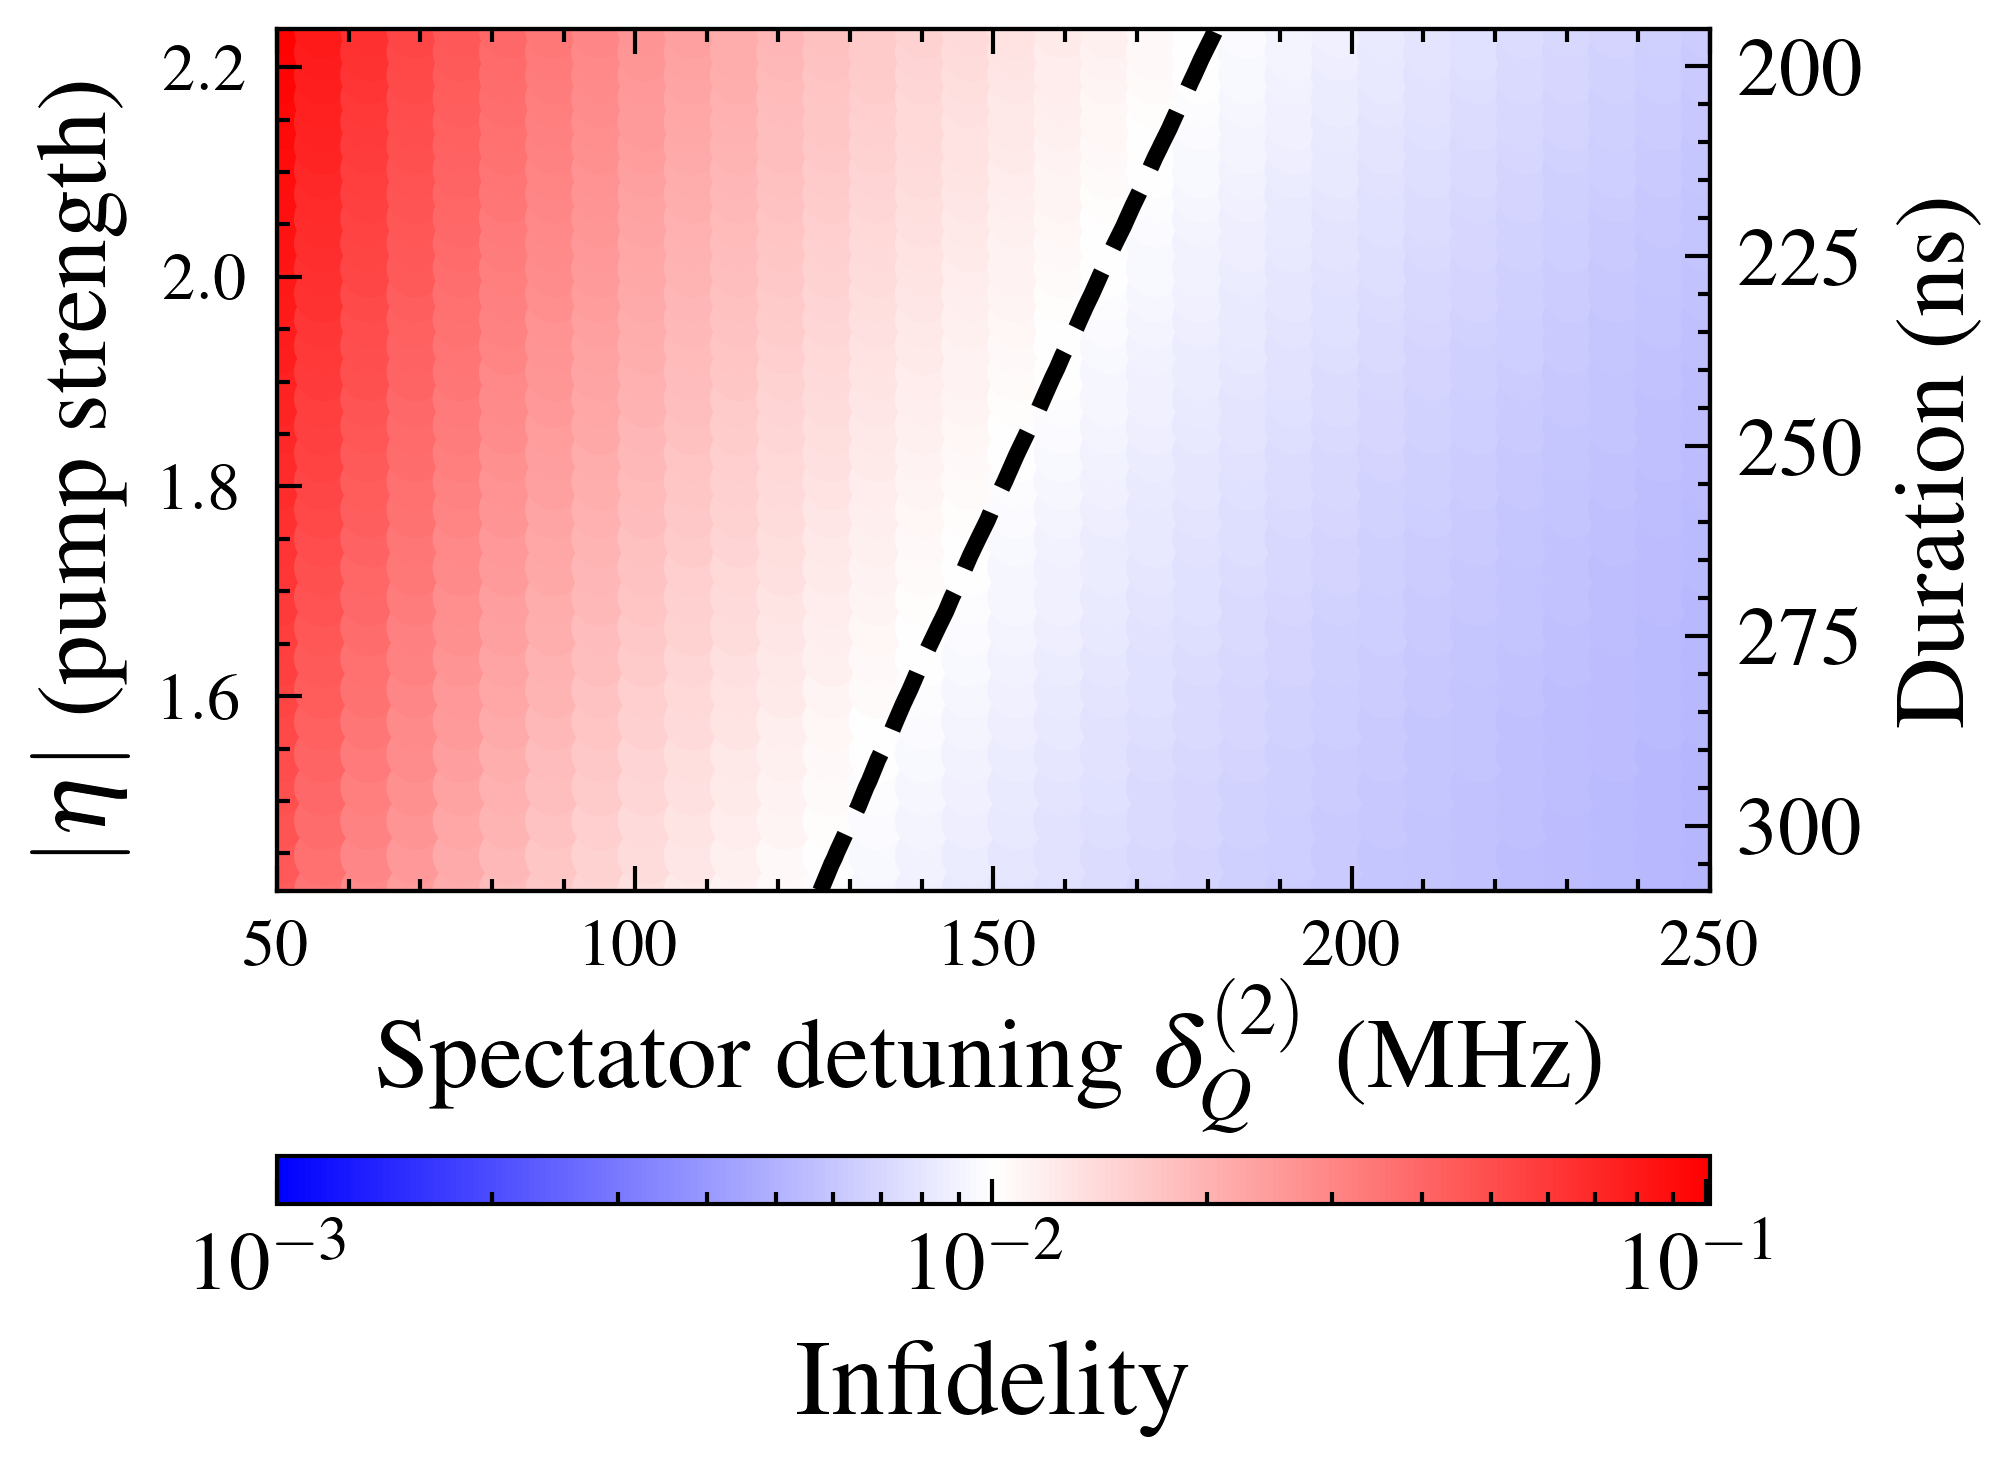

In [12]:
from matplotlib.colors import LogNorm

# First, determine global min and max fidelity
all_fidelities = np.concatenate([d["fidelity_list"] for d in data_store])
global_vmin, global_vmax = 0.0, np.max(all_fidelities)

# Now plot all data using the global color bar range
for data in data_store:
    gate_type = data["gate_type"]
    lambdaq = data["lambdaq"]
    T1 = data["T1"]
    fidelity_array = data["fidelity_list"]
    eta_array = np.sqrt(data["n_s_points"])
    delta_array = data["delta_points"]
    gate_durations = data["gate_durations"]

    # Plotting configuration
    norm = TwoSlopeNorm(
        vmin=global_vmin, vcenter=(1 - target_fidelity), vmax=global_vmax
    )
    norm = LogNorm(vmin=global_vmin + 1e-3, vmax=global_vmax)  # Avoid zero issues

    # Plotting
    with plt.style.context(["ieee", "use_mathtext", "science"]):
        fig, ax1 = plt.subplots()  # Adjust figure size for better proportions

        # Scatter plot for fidelity
        sc = ax1.scatter(
            delta_array, eta_array, c=fidelity_array, cmap="bwr", norm=norm, marker="o"
        )

        # Horizontal color bar below the plot
        cbar = plt.colorbar(
            sc, orientation="horizontal", pad=0.2, aspect=30
        )  # Adjust 'aspect' for length
        cbar.set_label("Infidelity", fontsize=13)  # Adjust color bar label size
        cbar.ax.tick_params(labelsize=10)  # Adjust tick label size on color bar

        # Labels for the main plot
        ax1.set_xlabel(
            r"Spectator detuning $\delta^{(2)}_Q$ (MHz)", fontsize=12, labelpad=-0.25
        )  # Increase font size for x-axis
        ax1.set_ylabel(
            r"$|\eta|$ (pump strength)", fontsize=12
        )  # Increase font size for y-axis
        # ax1.set_title(
        #     r"{} ( $\lambda = {:.2f}$, $T_1 = {:.0f} \, \mu$s )".format(
        #         gate_type, lambdaq, T1 * 1e6
        #     ),
        #     fontsize=16,
        # )  # Adjust title size and padding

        # Second y-axis for gate duration
        ax2 = ax1.twinx()
        ax2.set_ylabel(
            r"Duration (ns)", fontsize=12
        )  # Increase font size for the second y-axis
        # duration should be decreasing, we need to reverse the y-axis
        ax2.set_ylim(np.max(gate_durations), np.min(gate_durations))
        ax2.tick_params(labelsize=10)  # Adjust the tick label size on the second y-axis

        # Contour for target fidelity (e.g., 0.99)
        if global_vmin <= (1 - target_fidelity) <= global_vmax:
            triang = tri.Triangulation(delta_array, eta_array)
            ax1.tricontour(
                triang,
                fidelity_array,
                levels=[1 - target_fidelity],
                colors="black",
                linewidths=2,
                linestyles="dashed",
            )
        else:
            print(
                f"Warning: Target infidelity {1 - target_fidelity} is outside the range of calculated fidelities."
            )

        # Adjust layout to ensure everything fits well
        fig.tight_layout()

        # Save the plot as an SVG file with a unique filename
        plot_filename = f"{gate_type}_lambda_{lambdaq}_T1_{int(T1 * 1e6)}_us"
        plot_filename = (
            plot_filename.replace("\\", "").replace("$", "").replace(".", "") + ".pdf"
        )

        plot_filename = "../../img/qubit_spectator_boundaries/" + plot_filename

        plt.savefig(plot_filename)
        print(f"Saved: {plot_filename}")
        plt.show()